In [12]:
libs <- c(
    'tidyverse',
    'stringr',
    'GenomicRanges',
    'RPostgreSQL',
    'doMC',
    'numbers',
    'doParallel',
    'Matrix'

)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

library(BSgenome.Hsapiens.UCSC.hg38)
hg38 = BSgenome.Hsapiens.UCSC.hg38

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

At this point we have a few things:

* A subset of FIMO for only those motifs in our ChipSeq set, with:
    * A 9-to-1 ratio of negative to positive ChipSeq hits
    * Data about where there are hits and where there aren't
    * Data about which motifs overlap with HINT/Wellington and, for those that do, their number of overlaps and greatest magnitude score
* Maps between TFs and motifs
* A file that groups together motifs in families (based on class)

Now we're going to "annotate" that first dataset by overlaying the information in the other two. We'll load the TF-motif map first:

In [13]:
load("Rdata_files/Tfmotifmap.Rdata")

Now for the families, we'll load a text file. Below, we're showing the top, but basically, it contains:

1. The motif name
2. The "class" of the motif
3. The family of the motif

In [14]:
blah <- read_delim("text_data_files/motif_class_fam", delim = "\t") 
head(blah)

Parsed with column specification:
cols(
  ID = col_character(),
  class = col_character(),
  family = col_character()
)


ID,class,family
MA0151.1,ARID domain factors,ARID-related factors
MA0601.1,ARID domain factors,ARID-related factors
MA0602.1,ARID domain factors,ARID-related factors
MA0004.1,Basic helix-loop-helix factors (bHLH),PAS domain factors
MA0048.2,Basic helix-loop-helix factors (bHLH),Tal-related factors
MA0058.3,Basic helix-loop-helix factors (bHLH),bHLH-ZIP factors


Given our family/class info, we'll:

* Remove the family
* Trim the entries of any white space
* Filter so it's only things in our motif-TF mapping
* Split double classes into singles using "mutate" to make a list and tidyr::unnest to unlist that
* Add a dummy variable of "1" to each, used for counting in a bit...
* Remove any duplicates using dplyr::distinct (**good function to remember!**)
* Use tidyr::spread (**another good one to remember!**) to essentially expand the data
    * The "class" is the key, so these become column names
    * The "dummy_yesno" is the value, so these become the values for columns
    * We use 0 as the "fill" value, so as each existing key-value pair retains its 1, any non-existent one gets a 0
        * For example, if Motif_1 has Class_1, the Value for that (row,column) pair is 1
        * If Motif_1 DOES NOT have Class_1, the Value for that (row,column) pair is 0

As a result, we now have a data frame where each row is a motif, every column is a class, and every entry is either 1 or 0. It's essentially a sparse matrix, but with an extra column that contains each motif name. 

In [15]:
read_delim("text_data_files/motif_class_fam", delim = "\t") %>%
    # clean up and subset to only relevant motifs
    select("motifname" = "ID", class) %>%
    mutate_all(str_trim) %>%
    filter(motifname %in% relevant_motifs) %>% 
    # fix double classes
    mutate(class = str_split(class, "::")) %>% 
    unnest(class) %>%
    # create one-hot(ish, some double matches) version
    mutate(dummy_yesno = 1) %>%
    distinct %>%
    spread(class, dummy_yesno, fill = 0) -> blah

head(blah)

Parsed with column specification:
cols(
  ID = col_character(),
  class = col_character(),
  family = col_character()
)


motifname,Basic helix-loop-helix factors (bHLH),Basic leucine zipper factors (bZIP),C2H2 zinc finger factors,Fork head / winged helix factors,Heteromeric CCAAT-binding factors,High-mobility group (HMG) domain factors,Homeo domain factors,MADS box factors,Nuclear receptors with C4 zinc fingers,Other C4 zinc finger-type factors,Paired box factors,Rel homology region (RHR) factors,Runt domain factors,SMAD/NF-1 DNA-binding domain factors,STAT domain factors,TATA-binding proteins,Tryptophan cluster factors
MA0002.2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
MA0014.2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
MA0024.3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
MA0028.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
MA0030.1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
MA0031.1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
relevant_motifs <- unique(unlist(TFs.to.motifs))

read_delim("text_data_files/motif_class_fam", delim = "\t") %>%
    # clean up and subset to only relevant motifs
    select("motifname" = "ID", class) %>%
    mutate_all(str_trim) %>%
    filter(motifname %in% relevant_motifs) %>% 
    # fix double classes
    mutate(class = str_split(class, "::")) %>% 
    unnest(class) %>%
    # create one-hot(ish, some double matches) version
    mutate(dummy_yesno = 1) %>%
    distinct %>%
    spread(class, dummy_yesno, fill = 0) ->
    motif_class_hot

Parsed with column specification:
cols(
  ID = col_character(),
  class = col_character(),
  family = col_character()
)


In [17]:
str(motif_class_hot)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	195 obs. of  18 variables:
 $ motifname                               : chr  "MA0002.2" "MA0014.2" "MA0024.3" "MA0028.2" ...
 $ Basic helix-loop-helix factors (bHLH)   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Basic leucine zipper factors (bZIP)     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ C2H2 zinc finger factors                : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Fork head / winged helix factors        : num  0 0 1 0 1 1 1 1 0 0 ...
 $ Heteromeric CCAAT-binding factors       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ High-mobility group (HMG) domain factors: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Homeo domain factors                    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MADS box factors                        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Nuclear receptors with C4 zinc fingers  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Other C4 zinc finger-type factors       : num  0 0 0 0 0 0 0 0 1 1 ...
 $ Paired box factors                      : num  0 1 0 0 0 0 0 0 0 0 ...
 $ Rel homology reg

In [18]:
load("/ssd/mrichard/data/all.TF.df.fimo.hint.well.9.Rdata")

Now that we have a Motif-Class mapping for our motifs, we're going to load our big FIMO-esque dataset and add the class information to it as "annotation"

## merge in TF classes

Immediately, we add our 17 different classes to our FIMO-esque dataset, so now it has this information as well.

In [19]:
all.TF.df.fimo.hint.well.annotated <- left_join(all.TF.df.fimo.hint.well, motif_class_hot)

Joining, by = "motifname"


In [20]:
dim(all.TF.df.fimo.hint.well.annotated)
dim(all.TF.df.fimo.hint.well)

[1] 14674658       30

[1] 14674658       13

## merge in gc content

Now we want GC content, so we'll use GenomicRanges to write a function that uses the start/end/chrom to get the sequence, then basically count the C's and G's and get their frequencies (in percentage I think). 

We apply this to the whole BIG annotated dataset to add a "gc_content" column. This takes a while because it's like 15 million lines. 

In [23]:
# TODO: runs out of memory on pnr 49 dataset -- make more efficient?

In [24]:
get_gc_content <- function(start_col, end_col, chrom_col, b=100) {
    require(GenomicRanges)
    
    window_center <- round((start_col + end_col)/2)
    windows <- getSeq(hg38, paste0("chr",chrom_col), window_center-b, window_center+b)

    alph_freq <- alphabetFrequency(windows)
    gc_content <- rowSums(alph_freq[,c("C","G")])/(2*b+1)
    
    return(gc_content)
}

In [25]:
all.TF.df.fimo.hint.well.annotated %>%
    mutate("gc_content" = get_gc_content(start,endpos,chrom)) ->
    all.TF.df.fimo.hint.well.annotated

## merge in tss distance

We want to add info on the transcription start site (TSS), so we're going to connect to our genome database (hg38) and pull out all entries for protein coding genes. The info we'll grab is the chromosome, start/end/strand (location), and the gene name.

In [27]:
db_gtf <- dbConnect(PostgreSQL(), user= "trena", password="trena", dbname="gtf", host="whovian")
query <- "select * from hg38human where moleculetype='gene' and gene_biotype='protein_coding'"
tss_raw_table <- dbGetQuery(db_gtf, query)[, c("chr", "gene_name", "start", "endpos","strand")]

To that initial table of all genes, we'll:

1. Add a "ref" column that looks at strand and decides whether to start at the start or end.
2. Grab just the "ref" and "chr" columns, renaming them to "chrom" and "ts_start"
3. Remove X/Y/MT chromosomes from the dataset
4. Remove the "chr" from chromosome using stringr::str_sub

So what we have is a 2-column data frame with chromosome number mapped to TSS

In [28]:
tss_raw_table %>%
    mutate(ref = ifelse(strand == '+', start, endpos)) %>%
    select("chrom" = "chr", "ts_start" = "ref") %>%
    filter(!(chrom %in% c('chrMT','chrX','chrY'))) %>%
    mutate(chrom=str_sub(chrom,  start = 4)) ->
    tss_tbl

We're using the GenomicRanges again, and we're making our giant annotated table into that object, plus our new TSS table. Why?? Because then we can use the "distanceToNearest" to find the nearest TSS to each motif!

In [31]:
motif_gr <- makeGRangesFromDataFrame(all.TF.df.fimo.hint.well.annotated, start.field="start", end.field="endpos")
tss_gr <- makeGRangesFromDataFrame(tss_tbl, start.field="ts_start", end.field="ts_start")
dist_to_nearest_tss <- distanceToNearest(motif_gr, tss_gr, select="arbitrary")
tss_dists <- mcols(dist_to_nearest_tss)[,1]

We add the TSS to the data, but we take the arc-sinh of it so as not to have it all skewed. 

In [32]:
all.TF.df.fimo.hint.well.annotated %>%
    mutate(asinh_tss_dist = asinh(tss_dists)) ->
    all.TF.df.fimo.hint.well.annotated

## Save data

In [33]:
# load("/ssd/mrichard/data/all.TF.df.fimo.hint.well.annotated.9.Rdata")

Before saving, we do a bit of data manipulation again:

* Change HINT/Wellington counts to fractions by dividing by the maximum vaue
    * Each is basically normalized
* Remove the counts themselves, now that we have the fractions
* Rearrange so that TF classes come last (using the "everything()" helper)
    * Note that the GC ontent and TSS distance come right beforehand

In [34]:
# change hint and wellington counts to fractions
# rearrange column order to keep TF classes last. 

all.TF.df.fimo.hint.well.annotated %>%
mutate(h_frac = h_count/max(h_count)) %>%
mutate(w_frac = w_count/max(w_count)) %>%
select(-one_of("h_count","w_count")) %>%
select(motifname:w_min_score, h_frac, w_frac, gc_content, asinh_tss_dist, everything()) ->
all.TF.df.fimo.hint.well.annotated

In [35]:
save(all.TF.df.fimo.hint.well.annotated, file="/ssd/mrichard/data/all.TF.df.fimo.hint.well.annotated.9.Rdata")

## Explore some annotations

Now we have info on TF class for each motif, GC content, and distance to nearest TSS. We'll make 3 plots to explore:

1. Looking at distribution of TSS proximity for ChipSeq positive/negative

*Based on the plot, looks like we're much more likely to find a positive close to a TSS*

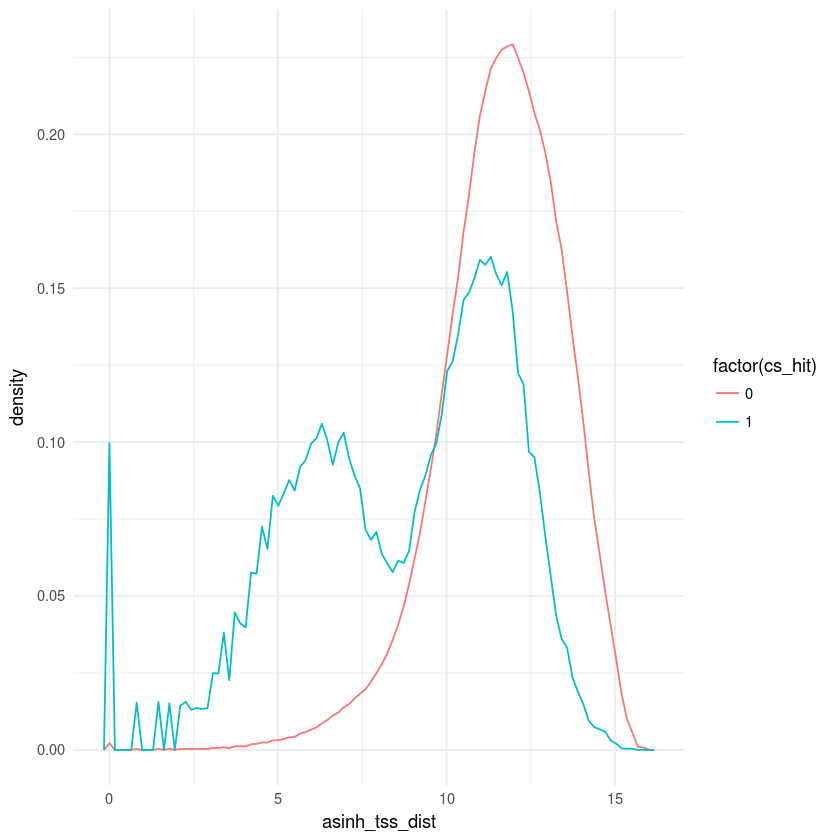

In [31]:
all.TF.df.fimo.hint.well.annotated %>%
ggplot +
geom_freqpoly(aes(x=asinh_tss_dist, y= ..density.., color=factor(cs_hit)), bins=100) +
theme_minimal()

2. Looking at distribution of GC content for ChipSeq positive/negative 

*Looks like ChipSeq hits tend to have higher GC content*

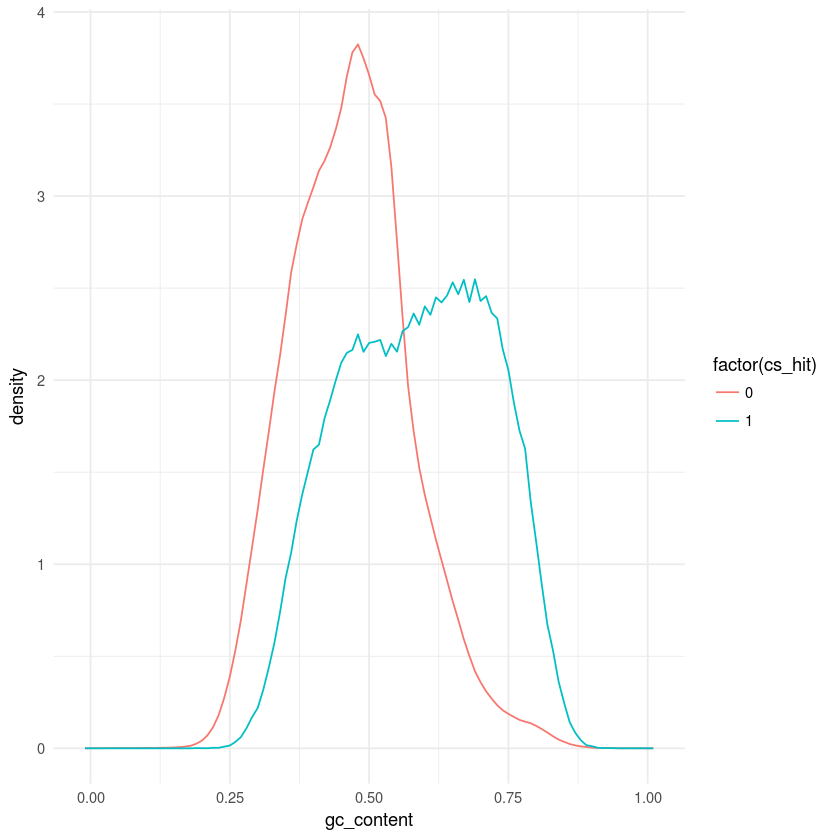

In [32]:
all.TF.df.fimo.hint.well.annotated %>%
ggplot +
geom_freqpoly(aes(x=gc_content, y= ..density.., color=factor(cs_hit)), bins=101) +
theme_minimal()

3. Looking at a scatterplot of GC content v. TSS distance for ChipSeq positive/negative. 

*Looks like we see 2 pretty distinct clusters, with higher distance from TSS and lower GC content corresponding to negative ChipSeq points.*

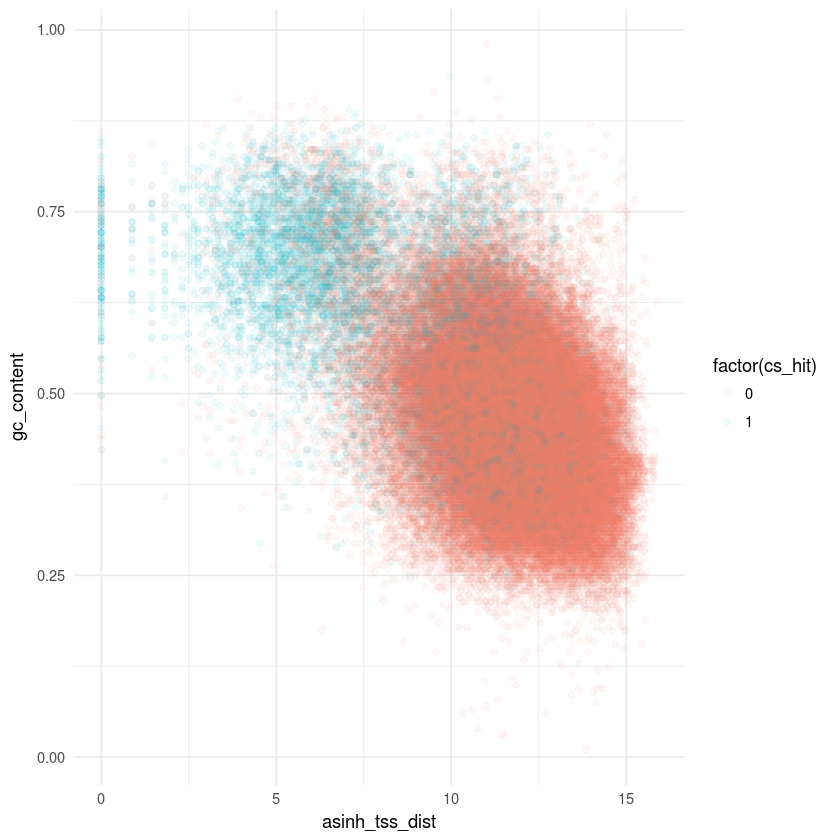

In [33]:
all.TF.df.fimo.hint.well.annotated %>%
sample_n(100000) %>%
ggplot +
geom_point(
    aes(x=asinh_tss_dist,
        y=gc_content,
        color=factor(cs_hit)),
    alpha=0.05) +
theme_minimal()